In [ ]:
#| default_exp predict
# all_slow

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/marcomatteo/steel_segmentation/blob/master/nbs/08_predict.ipynb)

In [ ]:
#| include: false
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#| include: false
from nbdev.showdoc import *

In [ ]:
#| export
from steel_segmentation.metadata import *
from steel_segmentation.masks import *
from steel_segmentation.datasets import *
from steel_segmentation.dataloaders import *
from steel_segmentation.metrics import *
from steel_segmentation.loss import *
from steel_segmentation.trainer import *

import fastai
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *

import os
import cv2
import pathlib
import numpy as np
import pandas as pd
import warnings
import zipfile
from tqdm import tqdm

from torch.utils.data import DataLoader, Dataset, sampler
import albumentations as alb

import segmentation_models_pytorch as smp

In [ ]:
#| missing
print_competition_data(models_dir)

../models/fastai-UNET-ResNet34-256-stage5.pth
../models/resnet18_class.pth
../models/FPN-fastai-ResNet34-stage1.pth
../models/exports
../models/.ipynb_checkpoints
../models/ResNet18-stage1-f1_0918.pth
../models/kaggle-UNET-ResNet34.pth
../models/ResNet18-encoder.pt
../models/logs
../models/kaggle-FPN-ResNet34.pth
../models/efficientnet_b2-UNET-stage0.pth
../models/resnet18-UNET-stage0.pth


## Fast.ai prediction

In [ ]:
arch = resnet34
dls = get_segmentation_dls_from_df(train_df=train_multi.iloc[:100], bs=2, size=(256,1600))
segmentation_learner = unet_learner(dls=dls, arch=arch, pretrained=True, model_dir=models_dir)

In [ ]:
#| missing
segmentation_learner = segmentation_learner.load("fastai-UNET-ResNet34-256-stage5")

In [ ]:
#| export
class FastPredict:
    pred_mask_path = pred_path / "prediction_masks"
    
    def get_df_source_list(self):
        """Load `source` if it's a DataFrame instance."""
        tfm = ColReader("ImageId", pref=self.source_path)
        return L([tfm(o) for o in self.source.itertuples()])
        
    def get_path_source_list(self):
        """Load `source` if it's a pathlib.Path instance."""
        return get_image_files(self.source)
    
    def __init__(self, 
                 source, 
                 learner,
                 source_path:pathlib.Path=None):
        """
        A FastPredict object has:
        - source: key to load a list of images
        - learner: a fastai Learner object
        - source_path: the folder path to the images 
        """
        self.source = source 
        self.learner = learner
        self.source_path = source_path if source_path else train_path
        
        self.single_prediction = False
        
        if isinstance(self.source, pathlib.Path):
            self.img_paths = self.get_path_source_list()
        elif isinstance(self.source, pd.DataFrame):
            self.img_paths = self.get_df_source_list()
        elif isinstance(self.source, list):
            self.img_paths = self.source
        elif isinstance(self.source, str):
            self.single_prediction = True
            self.img_paths = L(self.source_path / self.source)

        self.elems = len(self.img_paths)
    
    def __call__(self, size_fold:int, threshold:float, min_size:int):
        """Call the object with prediction attributes, 
        it calls `Predict.get_predictions`
        and returns the `Predict.df` DataFrame with RLEs."""
        self.size_fold = min([self.elems, size_fold])
        self.threshold = threshold
        self.min_size = min_size
        self.folds = self.elems // self.size_fold
        
        if (self.elems % self.size_fold) != 0:
            self.folds += 1
            
        self.df = self.get_predictions()
        return self.df
    
    def get_predictions(self):
        """Iterate through `Predict.folds`, predict the mask and
        get the RLEs in a DataFrame."""
        df_preds = []
        
        for fold in range(self.folds):
            start, end = fold*self.size_fold, (fold+1)*self.size_fold
            print(f"From {start} to {end} of {self.elems}")
            
            selected_imgs = self.img_paths[start:end]
            
            img_names = selected_imgs.map(Path).map(lambda x: x.name)
            pred_probs = self.predict(selected_imgs)            
            
            tmp_df = self.get_RLEs(img_names, pred_probs)
            df_preds.append(tmp_df)

            torch.cuda.empty_cache()
        
        if len(df_preds) == 1:
            return df_preds[0]
        
        df = pd.concat(df_preds, axis=0, ignore_index=True)
        return df.fillna("")
    
    def predict(self, selected_imgs):
        """Get the predictions on the `selected_imgs`."""
        if self.single_prediction:
            pred_full_dec, pred_dec, out = self.learner.predict(selected_imgs[0])
            return out.unsqueeze(dim=0)
            
        test_dl = self.learner.dls.test_dl(test_items=selected_imgs)
        pred_probs,_,_ = self.learner.get_preds(dl=test_dl, with_decoded=True)
        
        return pred_probs
    
    def get_RLEs(self, img_names, pred_probs):
        """For each image in the batch to predict, 
        returns a list of tuples with `(img_id, rle)`."""
        predictions = []
        
        for num_pred, t_pred in enumerate(pred_probs): # img in bs
            np_pred = t_pred.numpy()

            # iterate through class_id without class_id 0
            for class_id, prob in enumerate(np_pred[1:]): 
                pred, num = self.post_process(prob)
                rle = mask2rle(pred)
                name = img_names[num_pred] + f"_{class_id+1}"
                predictions.append([name, rle])
        
        return pd.DataFrame(predictions, columns=['ImageId_ClassId', 'EncodedPixels'])
    
    def post_process(self, probability):
        """
        Post processing of each predicted mask, components with lesser number of pixels
        than `min_size` are ignored.
        """
        mask = cv2.threshold(probability, self.threshold, 1, cv2.THRESH_BINARY)[1]
        num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
        predictions = np.zeros((256, 1600), np.float32)
        num = 0
        for c in range(1, num_component):
            p = (component == c)
            if p.sum() > self.min_size:
                predictions[p] = 1
                num += 1
        return predictions, num
    
    def save_masks(self, df_export_fname=None, make_zip=True):
        """
        If `df_export_fname` save predicted masks in 
        `pred_path / df_export_fname` in CSV and the JSON.
        Otherwise the file are named "predictions.csv" and "predictions.json".
        Saving the zip of the masks if `make_zip`.
        
        Run this method after __call__.
        """
        if not hasattr(self, 'df'):
            print("Predictions missing. Call the Prediction object first!")
            raise KeyError("Missing self.df, first run self.__call__ to get predictions")
        
        self.df_masks = self.make_masks()
        
        if not df_export_fname:
            df_export_fname = "predictions"
            
        csv_name = pred_path/(df_export_fname + ".csv")
        json_name = pred_path/(df_export_fname + ".json")
        self.df_masks.to_csv(csv_name, index=False)
        self.df_masks.to_json(json_name, orient="table", indent=4)
        
        if make_zip:
            zip_fname = df_export_fname + ".zip"
            with zipfile.ZipFile(pred_path/zip_fname, 'w', zipfile.ZIP_DEFLATED) as zipf:
                self.zipdir(zipf)
            
    def make_masks(self):
        """
        Iterate through the RLEs in `Predict.df` and save the masks.
        Returns the `Predict.df_masks` DataFrame (if not `json`) with
        `columns=['ImageId', 'ClassId', 'Mask_path']`.
        """
        self.pred_mask_path.mkdir(parents=True, exist_ok=True)

        rows = []
        for row in self.df.itertuples():
            if row.EncodedPixels != '':
                img_id, class_id = row.ImageId_ClassId.split("_")
                img_id = img_id.split(".")[0]
                img_label = img_id + "_pred.png"
                img_path = self.pred_mask_path / img_label

                mask = rle2mask(row.EncodedPixels, 1, (256, 1600))
                im = Image.fromarray(mask)
                im.save(img_path)

                rows.append((img_id + ".jpg", class_id, img_label))
        
        return pd.DataFrame(rows, columns=['ImageId', 'ClassId', 'Mask_path'])
    
    def zipdir(self, ziph:zipfile.ZipFile, pfolder=None):
        """Zip the current `self.pred_mask_path` directory,
        otherwise zip the `path` dir if provided."""
        if not pfolder:
            pfolder = self.pred_mask_path

        if not isinstance(pfolder, pathlib.Path):
            pfolder = Path(pfolder)

        for root,dirs,files in os.walk(pfolder):
            root = Path(root)
            for file in files:
                fname = root / file
                ziph.write(filename=fname,
                           arcname =os.path.relpath(fname,fname.parent))
                
    def save_submission(self, fname="test_submission"):
        """Save submission file in CSV in `sub_path`. 
        It adds always .csv at the end of `fname`."""
        if not hasattr(self, 'df'):
            raise KeyError("Call the object first to get the predictions")
        
        file_path = sub_path / (fname + '.csv')
        self.df.to_csv(file_path, index=False)
    
#    def plot(self, n:int=5, rand=False):
#        """Plot `n` elements in `self.img_paths`. 
#        If `rand` prints shuffle images."""
#        if (not hasattr(self, 'df_masks'))|(not hasattr(self, 'df')):
#            return "Nothing to plot, first call make_masks"

#        path_list = self.img_paths.map(Path)
        
#        if rand:
            #path_list = get_perm_imgs_path(self.img_paths.map(Path), self.df_masks)   
#            path_list = path_list.shuffle()
            
#        df = self.df.copy()
#        splitted_cols = df["ImageId_ClassId"].str.split("_", expand=True)
#        df["ImageId"], df["ClassId"] = splitted_cols[0], splitted_cols[1].astype("int64")
        
#        for p in path_list[:n]:
#            imgid, mask = make_mask(p, flatten=True, df=df)
#            img = cv2.imread(str(p))
#            plot_mask_image(imgid, img, mask)

The `Predict` class needs a `source` and a `source_path` when `source` is:
- a `str` for the `ImageId` of a single image
- a dataframe with the `ImageId` column.

Otherwise `source` can be a list (`L`) of paths or a single `Path` object.

How to use:
1. Setup the `Predict` class: create an instance with `pred = Predict(*args)`.
2. Call the object (e.g. `pred`) with the parameters: `size_fold` is the number of elements to infer toghether, `threshold` is the threshold for the probabilities from the activation function, `min_size` needs to ignore components in the predicted masks with few number of pixels (to reduce the false positive rate).
3. Get the predictions `DataFrame` with the `ImageId_ClassId` and the `EncodedPixels` columns.

In [ ]:
df_tmp = segmentation_learner.dls.valid.items.iloc[:5]
print(df_tmp.shape)

pred = FastPredict(df_tmp, segmentation_learner) # with a pd.DataFrame source

(1, 2)


In [ ]:
show_doc(FastPredict.__call__)

<h4 id="FastPredict.__call__" class="doc_header"><code>FastPredict.__call__</code><a href="__main__.py#L42" class="source_link" style="float:right">[source]</a></h4>

> <code>FastPredict.__call__</code>(**`size_fold`**:`int`, **`threshold`**:`float`, **`min_size`**:`int`)

Call the object with prediction attributes, 
it calls [`Predict.get_predictions`](/steel_segmentation/predict.html#Predict.get_predictions)
and returns the [`Predict.df`](/steel_segmentation/predict.html#Predict.df) DataFrame with RLEs.

In [ ]:
size_fold = 100
threshold = 0.5
min_size = 3000

In [ ]:
df_pred = pred(size_fold, threshold, min_size)
print(df_pred.shape)
df_pred.head()

From 0 to 1 of 1


(4, 2)


ImageId_ClassId  \
0  72aaba8ad.jpg_1   
1  72aaba8ad.jpg_2   
2  72aaba8ad.jpg_3   
3  72aaba8ad.jpg_4   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             EncodedPixels  
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
2  514 1 524 1 530 2 542 2 546 2 553 1 564 1 567 1 770 1 772 89 862 21 884 2 889 1 1024 124 1280 3 1285 57 1343 17 1365 1 1376 1 1378 2 1382 2 1385 5 1391 1 1538 2 1541 63 1609 5 1615 2 1620 2 1633 1 1637 5 1644 4 1794 1 1798 62 1867 3 1871 2 1874 1 1877 1 1888 2 1895 1 1903 1 2050 1 2054 1 2056 18 2076 6 2089 30 2122 10 2133 1 2144 5 2150 3 2158 2 2306 1 2308 3 2316 12 2329 1 2332 6 2340 32 2373 3 2377 13 2400 9 2562 112 2678 2 2816 1 2818 103 2924 2 2935 1 3072 92 3166 8 3176 1 3180 2 3184 2 3188 4 3328 114 3444 4 3449 2 3452 1 3584 112 3700 3 3704 7 3840 93 3934 16 3957 2 3961 3 3965 2 409...  
3

In [ ]:
df_tmp = train.iloc[0].to_frame().T # one element
print(df_tmp.shape)

pred = FastPredict(df_tmp, segmentation_learner)

df_pred = pred(size_fold, threshold, min_size)
df_pred

(1, 4)
From 0 to 1 of 1


ImageId_ClassId  \
0  72aaba8ad.jpg_1   
1  72aaba8ad.jpg_2   
2  72aaba8ad.jpg_3   
3  72aaba8ad.jpg_4   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             EncodedPixels  
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
2  514 1 524 1 530 2 542 2 546 2 553 1 564 1 567 1 770 1 772 89 862 21 884 2 889 1 1024 124 1280 3 1285 57 1343 17 1365 1 1376 1 1378 2 1382 2 1385 5 1391 1 1538 2 1541 63 1609 5 1615 2 1620 2 1633 1 1637 5 1644 4 1794 1 1798 62 1867 3 1871 2 1874 1 1877 1 1888 2 1895 1 1903 1 2050 1 2054 1 2056 18 2076 6 2089 30 2122 10 2133 1 2144 5 2150 3 2158 2 2306 1 2308 3 2316 12 2329 1 2332 6 2340 32 2373 3 2377 13 2400 9 2562 112 2678 2 2816 1 2818 103 2924 2 2935 1 3072 92 3166 8 3176 1 3180 2 3184 2 3188 4 3328 114 3444 4 3449 2 3452 1 3584 112 3700 3 3704 7 3840 93 3934 16 3957 2 3961 3 3965 2 409...  
3

In [ ]:
source = "f383950e8.jpg"
pred = FastPredict(source, segmentation_learner) # with str source
df_pred = pred(size_fold, threshold, min_size)
df_pred

From 0 to 1 of 1


ImageId_ClassId  \
0  f383950e8.jpg_1   
1  f383950e8.jpg_2   
2  f383950e8.jpg_3   
3  f383950e8.jpg_4   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             EncodedPixels  
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
2  514 1 516 1 527 17 551 4 560 2 566 3 571 1 603 1 770 1 772 112 886 1 888 3 892 2 1024 128 1281 75 1357 3 1364 2 1389 1 1536 1 1538 62 1601 2 1604 14 1620 2 1624 2 1642 2 1645 1 1792 67 1860 2 1864 11 1880 1 1899 1 2050 65 2116 13 2130 1 2136 4 2155 3 2305 2 2308 62 2371 13 2386 2 2389 1 2392 4 2400 2 2411 2 2560 94 2655 3 2659 11 2816 81 2898 2 2901 1 2903 3 2911 2 2917 4 2922 4 3072 92 3165 5 3174 6 3328 110 3584 110 3840 94 3935 15 4096 110 4352 110 4608 91 4704 1 4712 3 4717 1 4864 94 4959 5 4966 10 4979 1 4981 1 5120 107 5228 4 5233 7 5376 90 5469 1 5478 5 5485 1 5491 1 5632 108 5741 3...  
3

In [ ]:
show_doc(FastPredict.make_masks)

<h4 id="FastPredict.make_masks" class="doc_header"><code>FastPredict.make_masks</code><a href="__main__.py#L154" class="source_link" style="float:right">[source]</a></h4>

> <code>FastPredict.make_masks</code>()

Iterate through the RLEs in [`Predict.df`](/steel_segmentation/predict.html#Predict.df) and save the masks.
Returns the [`Predict.df_masks`](/steel_segmentation/predict.html#Predict.df_masks) DataFrame (if not `json`) with
`columns=['ImageId', 'ClassId', 'Mask_path']`.

In [ ]:
pred.make_masks()

ImageId ClassId           Mask_path
0  f383950e8.jpg       3  f383950e8_pred.png

In [ ]:
show_doc(FastPredict.save_masks)

<h4 id="FastPredict.save_masks" class="doc_header"><code>FastPredict.save_masks</code><a href="__main__.py#L126" class="source_link" style="float:right">[source]</a></h4>

> <code>FastPredict.save_masks</code>(**`df_export_fname`**=*`None`*, **`make_zip`**=*`True`*)

If `df_export_fname` save predicted masks in 
`pred_path / df_export_fname` in CSV and the JSON.
Otherwise the file are named "predictions.csv" and "predictions.json".
Saving the zip of the masks if `make_zip`.

Run this method after __call__.

In [ ]:
pred.save_masks()

In [ ]:
pred_path.ls()

(#8) [Path('../data/predictions/validation_masks.json'),Path('../data/predictions/validation_masks.zip'),Path('../data/predictions/predictions.csv'),Path('../data/predictions/.ipynb_checkpoints'),Path('../data/predictions/validation_masks.csv'),Path('../data/predictions/predictions.zip'),Path('../data/predictions/predictions.json'),Path('../data/predictions/prediction_masks')]

In [ ]:
show_doc(FastPredict.save_submission)

<h4 id="FastPredict.save_submission" class="doc_header"><code>FastPredict.save_submission</code><a href="__main__.py#L194" class="source_link" style="float:right">[source]</a></h4>

> <code>FastPredict.save_submission</code>(**`fname`**=*`'test_submission'`*)

Save submission file in CSV in [`sub_path`](/steel_segmentation/metadata.html#sub_path). 
It adds always .csv at the end of `fname`.

In [ ]:
pred.save_submission()

In [ ]:
tmp_path = sub_path/"test_submission.csv"
assert tmp_path.is_file()

In [ ]:
#| include: false
# show_doc(FastPredict.plot)

In [ ]:
#| include: false
#pred.plot(n=1, rand=False)

## Pytorch prediction

In [ ]:
#| export
class TestDataset(Dataset):
    """Dataset for test prediction"""

    def __init__(self, root:pathlib.Path, df:pd.DataFrame, mean=None, std=None):
        """
        A TestDataset loads the images from the `root` folder
        and the `ImageId`s from `df` with normalization params.
        """
        self.root = root
        self.fnames = df['ImageId'].unique().tolist()
        self.num_samples = len(self.fnames)
        
        if (mean is None) or (std is None): 
            mean, std = imagenet_stats
            
        self.transform = alb.Compose(
            [
                alb.Normalize(mean=mean, std=std, p=1),
                alb.pytorch.ToTensor(),
            ]
        )

    def __getitem__(self, idx):
        fname = self.fnames[idx]
        fpath = self.root / fname
        image = cv2.imread(str(fpath))
        image_tensor = self.transform(image=image)["image"]
        return fname, image_tensor

    def __len__(self):
        return self.num_samples

In [ ]:
train_multi.head(3)

ClassId        ImageId ClassId_multi
0        0002cc93b.jpg             1
1        00031f466.jpg             0
2        000418bfc.jpg             0

In [ ]:
test_dataset = TestDataset(root=train_path, df=train_multi)

In [ ]:
#| missing
img_name, img_tensor = test_dataset[0]
img_name, img_tensor.shape

('0002cc93b.jpg', torch.Size([3, 256, 1600]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


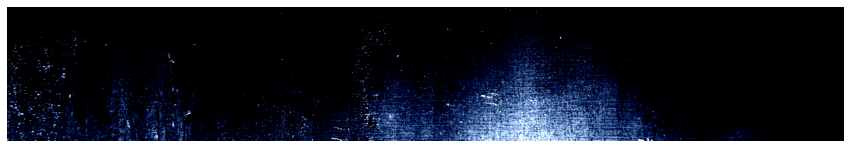

In [ ]:
#| missing
show_image(img_tensor, figsize=(15,5));

In [ ]:
#| export
def get_test_dls(
        root:pathlib.Path=None, df:pd.DataFrame=None, mean=None, std=None,
        num_workers=2, batch_size=4, shuffle=False, pin_memory=True,
        *args, **kwargs
    ):
    """Returns a Pytorch Dataloader for inference."""
    if df is None: df = test_df
    if root is None: root = test_path
    
    return DataLoader(
        TestDataset(root, df, mean, std),
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory=pin_memory,
        *args, **kwargs
    )

To make predictions we need to iterate through the dataset and grab one batch at the time. The `get_test_dls` function returns by default a `DataLoader` built on the `test_df` (submission csv) and `test_path` directory (test images). Without any argument can be used to make the submission to the Kaggle competition.

In [ ]:
#| missing
test_dls = get_test_dls()
test_eq(len(test_dls), 1377)

In [ ]:
#| missing
namesb, xb = next(iter(test_dls))
namesb, xb.shape

(['0000f269f.jpg', '000ccc2ac.jpg', '002451917.jpg', '003c5da97.jpg'],
 torch.Size([4, 3, 256, 1600]))

To load the validation images:

In [ ]:
#| missing
valid_dls = get_test_dls(root=train_path, df=train_multi.sample(100))
test_eq(len(valid_dls), 25) # with 4 batch size

In [ ]:
#| export
class Predict:
    def __init__(self, dl, model, device="cuda"):
        self.dl = dl
        self.source = self.dl.dataset.fnames
        self.source_path = self.dl.dataset.root
        self.img_paths = L([self.source_path / p for p in self.source])
        self.elems = len(self.img_paths)

        self.device = torch.device(device)
        self.model = model.to(self.device)
        
    def __call__(self, threshold:float, min_size:int):
        """
        Call the object with prediction attributes, 
        it calls `Predict.get_predictions`
        and returns the `Predict.df` DataFrame with RLEs.
        """
        self.threshold = threshold
        self.min_size = min_size      
        self.df = self.get_predictions()
        return self.df
    
    def get_predictions(self):
        """
        Iterate through `dl`, predict the mask and
        save the RLEs in a DataFrame.
        Returns the DataFrame.
        """
        df_preds = []
        for i, batch in enumerate(tqdm(self.dl)):
            fnames, images = batch
            
            batch_preds = self.predict_batch(images)
            
            for fname, preds in zip(fnames, batch_preds):
                for cls, pred in enumerate(preds):
                    pred, num = self.post_process(pred)
                    rle = mask2rle(pred)
                    name = fname + f"_{cls+1}"
                    df_preds.append([name, rle])
                    
        return pd.DataFrame(df_preds, columns=['ImageId_ClassId', 'EncodedPixels'])
    
    def predict_batch(self, images):
        """Predict a single batch, returns the probabilities into numpy array"""
        
        batch_preds = torch.sigmoid(self.model(images.to(self.device)))
        return batch_preds.detach().cpu().numpy()
    
    def post_process(self, probability):
        """
        Post processing of each predicted mask, components with lesser number of pixels
        than `min_size` are ignored.
        """
        mask = cv2.threshold(probability, self.threshold, 1, cv2.THRESH_BINARY)[1]
        num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
        predictions = np.zeros((256, 1600), np.float32)
        num = 0
        for c in range(1, num_component):
            p = (component == c)
            if p.sum() > self.min_size:
                predictions[p] = 1
                num += 1
        return predictions, num
    
    def save_submission(self, fname="test_submission"):
        """Save submission file in CSV in `sub_path`. 
        It adds always .csv at the end of `fname`."""
        if not hasattr(self, 'df'):
            raise KeyError("Call the object first to get the predictions")
        
        file_path = sub_path / (fname + '.csv')
        self.df.to_csv(file_path, index=False)

In [ ]:
#| missing
ckpt_path = models_dir/"kaggle-FPN-ResNet34.pth"
model = smp.FPN("resnet34", encoder_weights='imagenet', classes=4, activation=None)
model.eval()
state = torch.load(ckpt_path, map_location=lambda storage, loc: storage)
model.load_state_dict(state["state_dict"])

<All keys matched successfully>

In [ ]:
#| missing
pred = Predict(valid_dls, model)

In [ ]:
threshold = 0.5
min_size = 3000

In [ ]:
#| missing
df_preds = pred(threshold, 1500)

100%|██████████| 25/25 [00:07<00:00,  3.39it/s]


In [ ]:
#| missing
df_preds.sample(5)

ImageId_ClassId EncodedPixels
96   1501f53a2.jpg_1              
118  6c9efa832.jpg_3              
111  30fc6e17e.jpg_4              
237  cc12d964f.jpg_2              
45   af1cd15ef.jpg_2

In [ ]:
#| include: false
from nbdev import nbdev_export

nbdev_export()

Converted 01_metadata.ipynb.
Converted 02_masks.ipynb.
Converted 03_datasets.ipynb.
Converted 04_dataloaders.ipynb.
Converted 05_metrics.ipynb.
Converted 06_loss.ipynb.
Converted 07_trainer.ipynb.
Converted 08_predict.ipynb.
Converted 09_visualize.ipynb.
Converted index.ipynb.
